# Animal Classification

This notebook demonstrates the use of convolutional neural networks (CNNs) to classify images from the "dataset_animals" dataset, containing five classes: sheep, cow, butterfly, elephant, and squirrel. The challenge is the small number of images per class.

## Contents
1. Basic CNN Architecture
- Architecture Details: input layer, two convolutional layers with ReLU, one max pooling, one global average pooling, and a softmax output layer
- Goal: evaluate initial performance on the train and test sets
2. Transfer Learning Enhancement
- Approach: assess the impact of data augmentation, compare three Keras pre-trained models: VGG16, ResNet50, and MobileNetV2
- Metrics: accuracy on training and testing datasets
3. Final Model Discussion
- Detailed explanation of the chosen architecture and training strategy, including adjustments made from insights in previous tasks

Author: Tammie Koh

Loading in the relevant libraries/ packages

In [69]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAvgPool2D
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Preprocess input function for VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16

# Preprocess input function for MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobilenetv2

# Preprocess input function for ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

Before training the models, I will ensure that there is an available GPU for faster computational time

In [2]:
print("TensorFlow version:", tf.__version__)
print("Metal plugin available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.1
Metal plugin available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
else:
    print("Using CPU")

Using GPU


Now let us load in the train and test data

In [5]:
# define the archive folder
data_path = os.path.join(os.getcwd(), 'dataset_animals')

Data points per category: {'butterfly': 1540, 'sheep': 1304, 'squirrel': 1290, 'cow': 1360, 'elephant': 1008}
Data points per category: {'butterfly': 362, 'sheep': 336, 'squirrel': 387, 'cow': 321, 'elephant': 295}


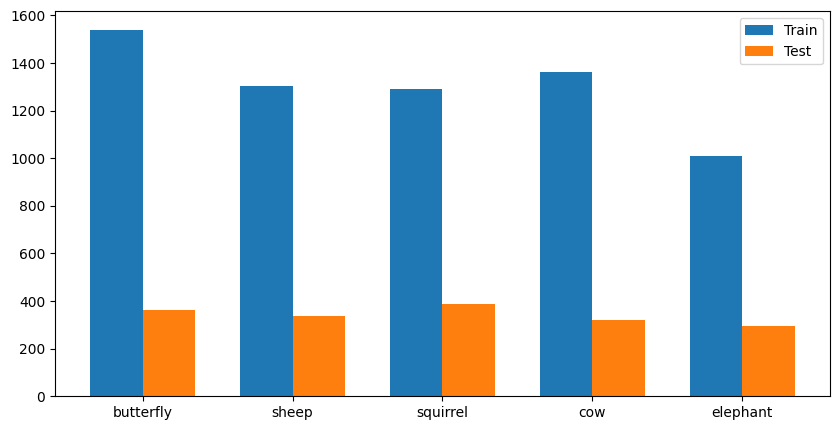

In [6]:
# Check how many data points we have in train, test, for each category
train_path = os.path.join(data_path, 'train')
categories = os.listdir(train_path)

# Remove the .DS_Store file
categories.remove('.DS_Store')
train_points = {}

# Iterate over the categories
for category in categories:
    train_points[category] = len(os.listdir(os.path.join(train_path, category)))

print(f'Data points per category: {train_points}')

# Test data
test_path = os.path.join(data_path, 'test')
test_points = {}

# Iterate over the categories
for category in categories:
    test_points[category] = len(os.listdir(os.path.join(test_path, category)))

print(f'Data points per category: {test_points}')

# Plot the data points as a side-by-side bar plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bar_width = 0.35
x = np.arange(len(categories))
bar1 = ax.bar(x, train_points.values(), bar_width, label='Train')
bar2 = ax.bar(x + bar_width, test_points.values(), bar_width, label='Test')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()
plt.show()

The class distributions indicate that the dataset is relatively balanced among the different categories. This slight imbalance in the dataset should be acceptable for initial explorations and training. Since the largest and smallest classes (butterfly and elephant, respectively) aren't drastically different in size, the model should learn to generalize across them reasonably well.

Next we will initialise `ImageDataGenerator` for training, validation and test set

In [7]:
# Use 10% of the data for validation
validation_split = 0.1

# Use the ImageDataGenerator to load in the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split
)
test_datagen = ImageDataGenerator(rescale=1./255)

# we will use the flow_from_directory method to load in the data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5849 images belonging to 5 classes.
Found 646 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.


# 1. Basic CNN Architecture

Now, we will define a simple CNN architecture:
- Input layer of shape (150, 150, 3)
- Two convolutional layers with ReLU activation and a max pooling layer in between
- A global average pooling layer followed by a dense output layer with softmax activation for five classes


In [12]:
# Specify the device for memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Enable memory growth for the specified device(s)
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [13]:
# Define the CNN architecture
model = models.Sequential([
    layers.InputLayer(input_shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(5, activation='softmax')
])

Now we will train the model. We will be using the Adam optimiser as it is often chosen for deep learning tasks, including CNNs, because of its efficiency and robustness, particularly with image data. Adam combines the advantages of two other optimizers (AdaGrad and RMSProp) by adapting the learning rate for each parameter, which helps in managing sparse and noisy data effectively. It's well-suited for models with a large number of parameters and requires less tuning of the optimiser settings


In [17]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.4919 - loss: 1.2355 - val_accuracy: 0.5015 - val_loss: 1.2573
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.5069 - loss: 1.2209 - val_accuracy: 0.5356 - val_loss: 1.2000
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.5181 - loss: 1.1980 - val_accuracy: 0.5279 - val_loss: 1.1907
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.5389 - loss: 1.1570 - val_accuracy: 0.5124 - val_loss: 1.2102
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5316 - loss: 1.1739 - val_accuracy: 0.5573 - val_loss: 1.1421
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5178 - loss: 1.1845 - val_accuracy: 0.5341 - val_loss: 1.1502
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.5486 - loss: 1.1338 - val_accuracy: 0.5495 - val_loss: 1.1293
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5492 - loss: 1.1285 - 

Let's take a look at how the model's accuracy has progressed throughout the training. We've plotted both training and validation accuracy against the number of epochs. This visual will help us understand if our model is improving and how well it's performing on unseen data compared to the training data

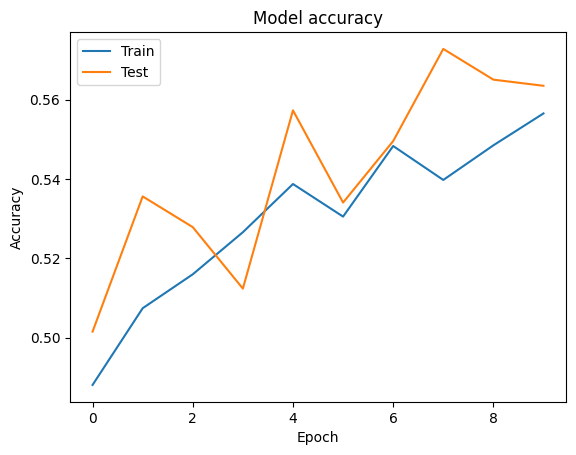

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


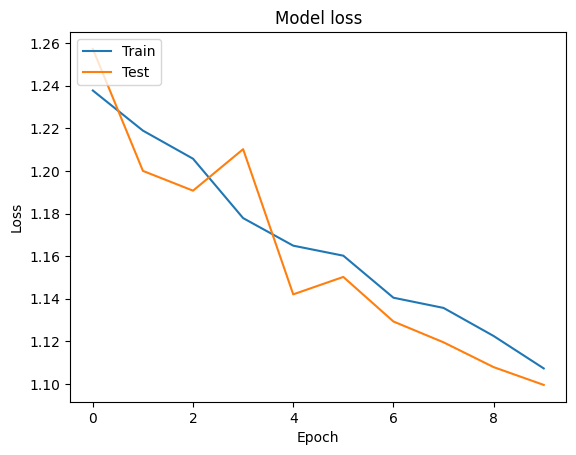

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5552 - loss: 1.1365
Test accuracy: 0.553791880607605


The performance is quite poor, however, we have not allowed the model to converge. To enhance our training strategy, we've implemented an Early Stopping mechanism. This monitors the validation loss and if it sees no improvement after three epochs, it'll stop the training. This saves resources and prevents the model from overfitting by restoring the weights from when the model performed best. We'll continue training for up to fifty additional epochs, but only if it's beneficial


In [23]:
additional_epochs = 50

# Define an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1, 
                               restore_best_weights=True)  # Whether to restore model weights from the epoch with the best value of the monitored quantity

# Continue training the model with the early stopping callback
history = model.fit(train_generator,
                    epochs=additional_epochs, 
                    validation_data=test_generator,
                    callbacks=[early_stopping])




Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5624 - loss: 1.0662 - val_accuracy: 0.5750 - val_loss: 1.0788
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5894 - loss: 1.0266 - val_accuracy: 0.5797 - val_loss: 1.0642
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.5898 - loss: 1.0370 - val_accuracy: 0.5802 - val_loss: 1.0755
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5906 - loss: 1.0122 - val_accuracy: 0.5926 - val_loss: 1.0410
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.5897 - loss: 1.0386 - val_accuracy: 0.5738 - val_loss: 1.0734
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.5924 - loss: 1.0125 - val_accuracy: 0.5432 - val_loss: 1.1146
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.5986 - loss: 0.9968 - val_accuracy: 0.5644 - val_loss: 1.0904
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


In [24]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc}')

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5909 - loss: 1.0519
Test accuracy: 0.5925925970077515


2024-04-20 15:52:18.244972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-20 15:52:18.245009: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16526163672947554180
2024-04-20 15:52:18.245017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[ArgMax/_6]]
2024-04-20 15:52:18.245024: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6506779763568279891
2024-04-20 15:52:18.245031: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4107746195075840439
2024-04-20 15:52:18.245066: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17821358900724499564
2024-04-20 15:52:1

# 2. Transfer Learning

Here we will:

1. Assess the significance of employing data augmentation by comparing its impact on the model performance. Experiment with both augmented and non-augmented datasets, and analyze the differences in the results

2. Evaluate the performance of a minimum of three pretrained models provided by Keras by measuring their accuracy on both the training and testing datasets. Compare and contrast their effectiveness in terms of classification accuracy

Before proceeding further, let's create a function responsible for returning the modified pretrained model along with its corresponding data loaders. This approach helps maintain code clarity and organization

In [26]:
def build_model_and_loaders(model, preprocessor, weights='imagenet', data_paths=[train_path, test_path], augment=False, validation_split=0.1):
    target_shape = (224, 224, 3)
    pretrained = model(weights=weights, include_top=False, input_shape=target_shape)
    pretrained.trainable = False

    # Generate new data loaders based on the model's specifications
    if not augment:        
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocessor,
            validation_split=validation_split
        )
    else:
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocessor,
            validation_split=validation_split,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )

    test_datagen = ImageDataGenerator(preprocessing_function=preprocessor)

    train_generator = train_datagen.flow_from_directory(
        data_paths[0],
        target_size=target_shape[0:2],
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_paths[0],
        target_size=target_shape[0:2],
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    test_generator = test_datagen.flow_from_directory(
        data_paths[1],
        target_size=target_shape[0:2],
        batch_size=32,
        class_mode='categorical'
    )
    
    model = Sequential([
        pretrained,
        GlobalAvgPool2D(),
        Dense(512, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model, train_generator, validation_generator, test_generator


## Without Data Augmentation

### VGG 16

- Developed by researchers at the Visual Graphics Group from Oxford (hence VGG), VGG16 is characterised by its simplicity, using only 3x3 convolutional layers stacked on top of each other in increasing depth. It uses max pooling to reduce volume size
- The uniformity of its architecture allows it to learn very effective hierarchical features from images. It’s quite robust and straightforward to implement, making it a great baseline for any image classification task
- It is quite large in terms of memory and computational cost and can be slower to train compared to some newer architectures

In [29]:
# Define vgg16 model
model_vgg16, train_generator_vgg16, validation_generator_vgg16, test_generator_vgg16 = build_model_and_loaders(VGG16, preprocess_input_vgg16)

# Train the model
history_vgg16 = model_vgg16.fit(train_generator_vgg16, validation_data=validation_generator_vgg16, epochs=10)

Found 5849 images belonging to 5 classes.
Found 646 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.
Epoch 1/10


/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


183/183 ━━━━━━━━━━━━━━━━━━━━ 123s 662ms/step - accuracy: 0.8563 - loss: 0.9159 - val_accuracy: 0.9598 - val_loss: 0.1026
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 127s 692ms/step - accuracy: 0.9751 - loss: 0.1054 - val_accuracy: 0.9443 - val_loss: 0.2324
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 131s 716ms/step - accuracy: 0.9850 - loss: 0.0433 - val_accuracy: 0.9536 - val_loss: 0.1736
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 142s 772ms/step - accuracy: 0.9913 - loss: 0.0263 - val_accuracy: 0.9520 - val_loss: 0.2016
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 158s 861ms/step - accuracy: 0.9915 - loss: 0.0278 - val_accuracy: 0.9690 - val_loss: 0.0860
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 167s 909ms/step - accuracy: 0.9950 - loss: 0.0149 - val_accuracy: 0.9628 - val_loss: 0.1127
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 171s 934ms/step - accuracy: 0.9980 - loss: 0.0111 - val_accuracy: 0.9706 - val_loss: 0.1017
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9946 - loss: 0.0177 

In [30]:
# Evaluate the VGG16 model on the test data
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_generator_vgg16)
print('Test accuracy for VGG16:', test_acc_vgg16)

/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 924ms/step - accuracy: 0.9581 - loss: 0.2285
Test accuracy for VGG16: 0.9629629850387573


### MobileNetV2

- MobileNetV2 is a compact neural network architecture tailored for mobile and edge devices, where computational resource is limited. It was engineered by Google researchers
- It stands out for its use of depthwise separable convolutions which significantly reduces the number of parameters without sacrificing model efficacy. This allows for a lightweight model that is not only fast but also efficient
- The architecture introduces linear bottlenecks and inverted residuals, which are innovations that preserve important information as data flows through the network
- Despite its reduced size, MobileNetV2 does not compromise performance and is well-suited for real-time applications and can handle large-scale image classification tasks effectively

In [31]:
# Define mobilenetv2 model
model_mobilenetv2, train_generator_mobilenetv2, validation_generator_mobilenetv2, test_generator_mobilenetv2 = build_model_and_loaders(MobileNetV2, preprocess_input_mobilenetv2)

# Train the model
history_mobilenetv2 = model_mobilenetv2.fit(train_generator_mobilenetv2, validation_data=validation_generator_mobilenetv2, epochs=10)

Found 5849 images belonging to 5 classes.
Found 646 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.
Epoch 1/10


/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


183/183 ━━━━━━━━━━━━━━━━━━━━ 61s 302ms/step - accuracy: 0.8852 - loss: 0.3026 - val_accuracy: 0.9613 - val_loss: 0.1168
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 240ms/step - accuracy: 0.9809 - loss: 0.0589 - val_accuracy: 0.9659 - val_loss: 0.1073
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 247ms/step - accuracy: 0.9880 - loss: 0.0364 - val_accuracy: 0.9690 - val_loss: 0.1108
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 43s 233ms/step - accuracy: 0.9899 - loss: 0.0296 - val_accuracy: 0.9675 - val_loss: 0.1199
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 44s 242ms/step - accuracy: 0.9967 - loss: 0.0149 - val_accuracy: 0.9628 - val_loss: 0.1236
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 49s 268ms/step - accuracy: 0.9994 - loss: 0.0047 - val_accuracy: 0.9582 - val_loss: 0.1257
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 46s 250ms/step - accuracy: 0.9925 - loss: 0.0185 - val_accuracy: 0.9582 - val_loss: 0.1524
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 45s 245ms/step - accuracy: 0.9978 - loss: 0.0063 - val

In [38]:
# Evaluate the MobileNetV2 model on the test data
test_loss_mobilenetv2, test_acc_mobilenetv2 = model_mobilenetv2.evaluate(test_generator_mobilenetv2)
print('Test accuracy for MobileNetV2:', test_acc_mobilenetv2)

54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.9770 - loss: 0.1088
Test accuracy for MobileNetV2: 0.9753086566925049


### ResNet50

- ResNet, which stands for Residual Network, was designed by researchers at Microsoft and introduces a novel architecture with "skip connections" or "shortcut connections.
- Its defining feature is the ability to add the output from an earlier layer to a later layer, which handles the vanishing gradient problem and allows the training of very deep networks. This characteristic of "learning residuals" ensures that the network can learn with increased depth without a degradation in accuracy.
- ResNet50, specifically, has 50 layers deep and is considerably deeper than VGG16 but with fewer parameters due to its use of global average pooling rather than fully connected layers
- ResNet models have a reputation for being highly effective for a wide range of image recognition tasks, offering both speed and efficiency during training and inference compared to older, deeper models like VGG16

In [32]:
# Define resnet50 model
model_resnet50, train_generator_resnet50, validation_generator_resnet50, test_generator_resnet50 = build_model_and_loaders(ResNet50, preprocess_input_resnet50)

# Train the model
history_resnet50 = model_resnet50.fit(train_generator_resnet50, validation_data=validation_generator_resnet50, epochs=10)

Found 5849 images belonging to 5 classes.
Found 646 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.
Epoch 1/10


/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


183/183 ━━━━━━━━━━━━━━━━━━━━ 123s 629ms/step - accuracy: 0.8595 - loss: 0.5527 - val_accuracy: 0.9675 - val_loss: 0.0996
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 116s 630ms/step - accuracy: 0.9801 - loss: 0.0684 - val_accuracy: 0.9737 - val_loss: 0.0834
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 115s 623ms/step - accuracy: 0.9853 - loss: 0.0434 - val_accuracy: 0.9737 - val_loss: 0.0941
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 115s 628ms/step - accuracy: 0.9933 - loss: 0.0230 - val_accuracy: 0.9644 - val_loss: 0.1136
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 100s 547ms/step - accuracy: 0.9967 - loss: 0.0111 - val_accuracy: 0.9706 - val_loss: 0.1152
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 100s 546ms/step - accuracy: 0.9980 - loss: 0.0091 - val_accuracy: 0.9737 - val_loss: 0.0970
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 105s 573ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9752 - val_loss: 0.1016
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 108s 589ms/step - accuracy: 0.9997 - loss: 0.00

In [33]:
# Evaluate the ResNet50 model on the test data
test_loss_resnet50, test_acc_resnet50 = model_resnet50.evaluate(test_generator_resnet50)
print('Test accuracy for ResNet50:', test_acc_resnet50)

/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 517ms/step - accuracy: 0.9810 - loss: 0.0685
Test accuracy for ResNet50: 0.9770722985267639


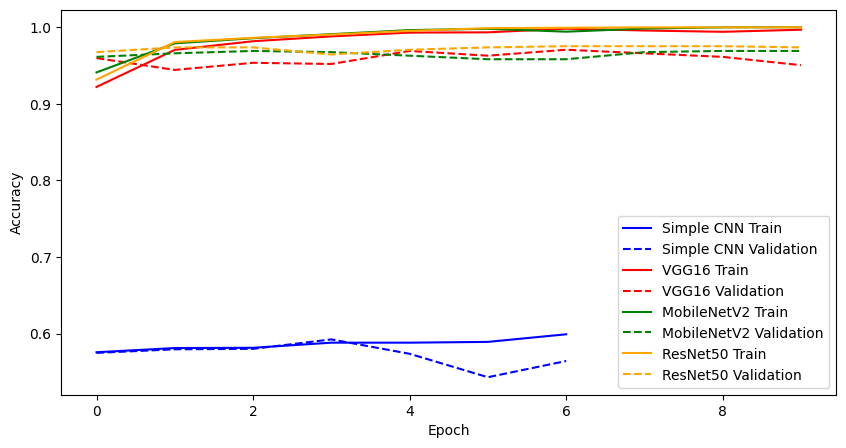

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['accuracy'], label='Simple CNN Train', color='blue')
ax.plot(history.history['val_accuracy'], label='Simple CNN Validation', color='blue', linestyle='dashed')
ax.plot(history_vgg16.history['accuracy'], label='VGG16 Train', color='red')
ax.plot(history_vgg16.history['val_accuracy'], label='VGG16 Validation', color='red', linestyle='dashed')
ax.plot(history_mobilenetv2.history['accuracy'], label='MobileNetV2 Train', color='green')
ax.plot(history_mobilenetv2.history['val_accuracy'], label='MobileNetV2 Validation', color='green', linestyle='dashed')
ax.plot(history_resnet50.history['accuracy'], label='ResNet50 Train', color='orange')
ax.plot(history_resnet50.history['val_accuracy'], label='ResNet50 Validation', color='orange', linestyle='dashed')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

Let's exclude the simple CNN model from the visualization to simplify the comparison of the pre-trained models. We'll plot the performance of the pre-trained models separately

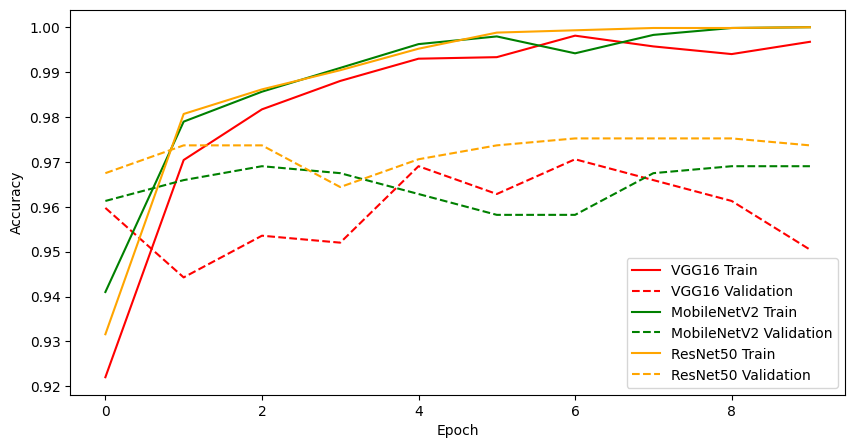

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history_vgg16.history['accuracy'], label='VGG16 Train', color='red')
ax.plot(history_vgg16.history['val_accuracy'], label='VGG16 Validation', color='red', linestyle='dashed')
ax.plot(history_mobilenetv2.history['accuracy'], label='MobileNetV2 Train', color='green')
ax.plot(history_mobilenetv2.history['val_accuracy'], label='MobileNetV2 Validation', color='green', linestyle='dashed')
ax.plot(history_resnet50.history['accuracy'], label='ResNet50 Train', color='orange')
ax.plot(history_resnet50.history['val_accuracy'], label='ResNet50 Validation', color='orange', linestyle='dashed')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

VGG16 consistently trails behind MobileNetV2 and ResNet50 in accuracy throughout the epochs, while ResNet50 consistently leads with the highest accuracy. ResNet50's validation line consistently outperforms the validation lines of the other models, suggesting superior generalization. Additionally, ResNet50's validation trend appears the smoothest among the three models, indicating stable performance across epochs

In [36]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.16.1


In [45]:
# Save all your models
model_vgg16.save('vgg16_model.keras')
model_mobilenetv2.save('mobilenetv2_model.keras')
model_resnet50.save('resnet50_model.keras')

# Save the weights separately because TensorFlow 2.16 has a major bug with saving/loading models
# Make sure to save as .h5 files
model_vgg16.save_weights('vgg16_model_weights.weights.h5')
model_mobilenetv2.save_weights('mobilenetv2_model.weights.h5')
model_resnet50.save_weights('resnet50_model.weights.h5')

## With Data Augmentation

### VGG 16

In [46]:
# Define the VGG16 augmented model
model_vgg16_aug, train_generator_vgg16_aug, validation_generator_vgg16_aug, test_generator_vgg16_aug = build_model_and_loaders(VGG16, preprocess_input_vgg16, augment=True)

# Train the model
history_vgg16_aug = model_vgg16_aug.fit(train_generator_vgg16_aug, validation_data=validation_generator_vgg16_aug, epochs=10)

Found 5849 images belonging to 5 classes.
Found 646 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.
Epoch 1/10


/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


183/183 ━━━━━━━━━━━━━━━━━━━━ 132s 697ms/step - accuracy: 0.8262 - loss: 1.1111 - val_accuracy: 0.9241 - val_loss: 0.2700
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 139s 748ms/step - accuracy: 0.9466 - loss: 0.2035 - val_accuracy: 0.9195 - val_loss: 0.2505
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 148s 794ms/step - accuracy: 0.9510 - loss: 0.1689 - val_accuracy: 0.9474 - val_loss: 0.1973
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 155s 836ms/step - accuracy: 0.9599 - loss: 0.1132 - val_accuracy: 0.9427 - val_loss: 0.1615
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 155s 839ms/step - accuracy: 0.9706 - loss: 0.0898 - val_accuracy: 0.9520 - val_loss: 0.1778
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 160s 864ms/step - accuracy: 0.9659 - loss: 0.1017 - val_accuracy: 0.9396 - val_loss: 0.1627
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 155s 834ms/step - accuracy: 0.9748 - loss: 0.0765 - val_accuracy: 0.9458 - val_loss: 0.1511
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 180s 972ms/step - accuracy: 0.9727 - loss: 0.06

In [54]:
# Evaluate the VGG16 augmented model on the test data
test_loss_vgg16_aug, test_acc_vgg16_aug = model_vgg16_aug.evaluate(test_generator_vgg16_aug)
print('Test accuracy for VGG16 augmented:', test_acc_vgg16_aug)

54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 751ms/step - accuracy: 0.9734 - loss: 0.0885
Test accuracy for VGG16 augmented: 0.9729570746421814


### MobileNetV2

In [48]:
# Define the MobileNetV2 model
model_mobilenetv2_aug, train_generator_mobilenetv2_aug, validation_generator_mobilenetv2_aug, test_generator_mobilenetv2_aug = build_model_and_loaders(MobileNetV2, preprocess_input_mobilenetv2, augment=True)

# Train the model
history_mobilenetv2_aug = model_mobilenetv2_aug.fit(train_generator_mobilenetv2_aug, validation_data=validation_generator_mobilenetv2_aug, epochs=10)

Found 5849 images belonging to 5 classes.
Found 646 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.
Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 91s 444ms/step - accuracy: 0.8673 - loss: 0.3946 - val_accuracy: 0.9536 - val_loss: 0.1276
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 78s 419ms/step - accuracy: 0.9503 - loss: 0.1388 - val_accuracy: 0.9334 - val_loss: 0.2117
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 74s 396ms/step - accuracy: 0.9614 - loss: 0.1136 - val_accuracy: 0.9458 - val_loss: 0.1445
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 96s 515ms/step - accuracy: 0.9643 - loss: 0.0984 - val_accuracy: 0.9211 - val_loss: 0.2707
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 74s 390ms/step - accuracy: 0.9670 - loss: 0.0918 - val_accuracy: 0.9536 - val_loss: 0.1317
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 70s 373ms/step - accuracy: 0.9722 - loss: 0.0783 - val_accuracy: 0.9536 - val_loss: 0.1491
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 64s 343ms/step - accuracy: 0.9762 - loss: 0.0723 

In [49]:
# Evaluate the MobileNetV2 augmented model on the test data
test_loss_mobilenetv2_aug, test_acc_mobilenetv2_aug = model_mobilenetv2_aug.evaluate(test_generator_mobilenetv2_aug)
print('Test accuracy for MobileNetV2 augmented:', test_acc_mobilenetv2_aug)

/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.9600 - loss: 0.1288
Test accuracy for MobileNetV2 augmented: 0.9664903283119202


### ResNet50

In [50]:
# Define the ResNet50 model
model_resnet50_aug, train_generator_resnet50_aug, validation_generator_resnet50_aug, test_generator_resnet50_aug = build_model_and_loaders(ResNet50, preprocess_input_resnet50, augment=True)

# Train the model
history_resnet50_aug = model_resnet50_aug.fit(train_generator_resnet50_aug, validation_data=validation_generator_resnet50_aug, epochs=10)

Found 5849 images belonging to 5 classes.
Found 646 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.
Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 141s 721ms/step - accuracy: 0.8741 - loss: 0.3899 - val_accuracy: 0.9102 - val_loss: 0.2266
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 117s 634ms/step - accuracy: 0.9592 - loss: 0.1073 - val_accuracy: 0.9598 - val_loss: 0.1126
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 122s 659ms/step - accuracy: 0.9678 - loss: 0.0907 - val_accuracy: 0.9443 - val_loss: 0.1504
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 122s 660ms/step - accuracy: 0.9702 - loss: 0.0916 - val_accuracy: 0.9350 - val_loss: 0.1685
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 139s 751ms/step - accuracy: 0.9694 - loss: 0.0819 - val_accuracy: 0.9520 - val_loss: 0.1238
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 126s 676ms/step - accuracy: 0.9745 - loss: 0.0830 - val_accuracy: 0.9582 - val_loss: 0.1041
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 120s 650ms/step - accuracy: 0.9782 - loss: 

In [51]:
# Evaluate the ResNet50 augmented model on the test data
test_loss_resnet50_aug, test_acc_resnet50_aug = model_resnet50_aug.evaluate(test_generator_resnet50_aug)
print('Test accuracy for ResNet50 augmented:', test_acc_resnet50_aug)

54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 536ms/step - accuracy: 0.9712 - loss: 0.1006
Test accuracy for ResNet50 augmented: 0.9753086566925049


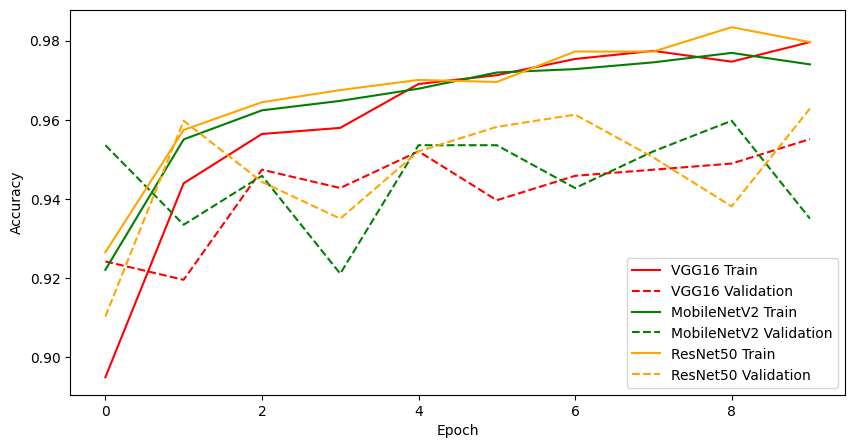

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history_vgg16_aug.history['accuracy'], label='VGG16 Train', color='red')
ax.plot(history_vgg16_aug.history['val_accuracy'], label='VGG16 Validation', color='red', linestyle='dashed')
ax.plot(history_mobilenetv2_aug.history['accuracy'], label='MobileNetV2 Train', color='green')
ax.plot(history_mobilenetv2_aug.history['val_accuracy'], label='MobileNetV2 Validation', color='green', linestyle='dashed')
ax.plot(history_resnet50_aug.history['accuracy'], label='ResNet50 Train', color='orange')
ax.plot(history_resnet50_aug.history['val_accuracy'], label='ResNet50 Validation', color='orange', linestyle='dashed')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend()

In [55]:
# Save all models
model_vgg16_aug.save('vgg16_augmented_model.keras')
model_mobilenetv2_aug.save('mobilenetv2_augmented_model.keras')
model_resnet50_aug.save('resnet50_augmented_model.keras')

# Save the weights separately because TensorFlow 2.16 has a major bug with saving/loading models
# Make sure to save as .h5 files
model_vgg16_aug.save_weights('vgg16_augmented_model.weights.h5')
model_mobilenetv2_aug.save_weights('mobilenetv2_augmented_model.weights.h5')
model_resnet50_aug.save_weights('resnet50_augmented_model.weights.h5')

I omitted the original simple CNN model as its performance would most definitely be much worse than the pre-trained models

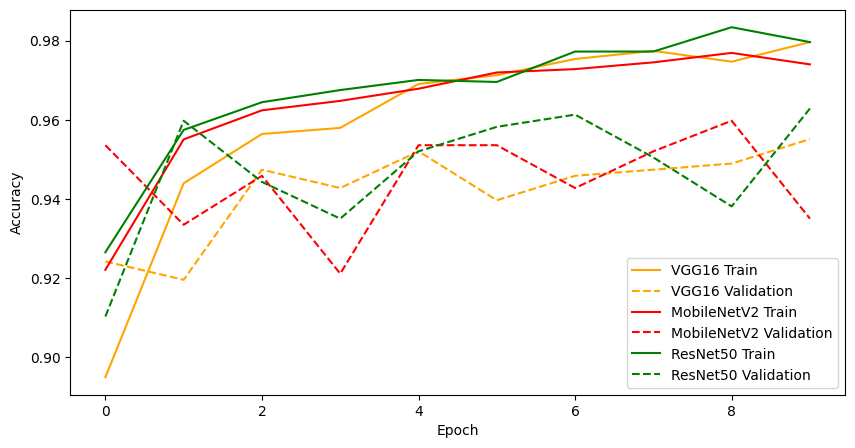

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history_vgg16_aug.history['accuracy'], label='VGG16 Train', color='orange')
ax.plot(history_vgg16_aug.history['val_accuracy'], label='VGG16 Validation', color='orange', linestyle='dashed')
ax.plot(history_mobilenetv2_aug.history['accuracy'], label='MobileNetV2 Train', color='red')
ax.plot(history_mobilenetv2_aug.history['val_accuracy'], label='MobileNetV2 Validation', color='red', linestyle='dashed')
ax.plot(history_resnet50_aug.history['accuracy'], label='ResNet50 Train', color='green')
ax.plot(history_resnet50_aug.history['val_accuracy'], label='ResNet50 Validation', color='green', linestyle='dashed')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

All models exhibit an upward trend in training accuracy, indicating learning progression. VGG16's training accuracy (solid orange) is slightly more volatile compared to MobileNetV2 (solid red) and ResNet50 (solid green), which both show smoother increases. The validation accuracies (dashed lines) for all models display fluctuations, with VGG16 (dashed orange) having the most pronounced swings, suggesting potential overfitting or instability in generalization. In contrast, MobileNetV2 and ResNet50 show more stable validation accuracies, with MobileNetV2’s validation performance slightly surpassing ResNet50's after the initial epochs. Overall, while all models learn effectively, MobileNetV2 shows a better balance between training progression and validation stability, possibly indicating better generalization performance

While data augmentation doesn't significantly enhance our results, it notably prolongs the training process. However, relying solely on accuracy may not provide a comprehensive evaluation. Let's examine the confusion matrices to ensure a thorough assessment

In [60]:
def generate_confusion_matrix(model, test_generator):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    cm = tf.math.confusion_matrix(y_true, y_pred)
    return cm

In [61]:
vgg16_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg16)
vgg16_generator_ns = vgg16_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

mobilenetv2_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenetv2)
mobilenetv2_generator_ns = mobilenetv2_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

resnet50_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50)
resnet50_generator_ns = resnet50_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1701 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.


/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 617ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 584ms/step


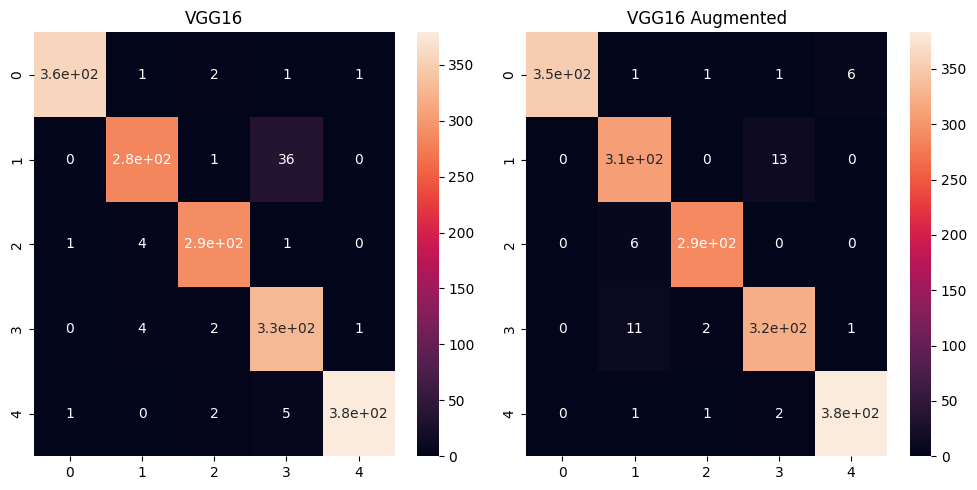

In [62]:
# VGG16
cm_vgg16 = generate_confusion_matrix(model_vgg16, vgg16_generator_ns)
cm_vgg16_aug = generate_confusion_matrix(model_vgg16_aug, vgg16_generator_ns)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(cm_vgg16, annot=True, ax=ax[0])
sns.heatmap(cm_vgg16_aug, annot=True, ax=ax[1])
ax[0].set_title('VGG16')
ax[1].set_title('VGG16 Augmented')

plt.tight_layout()

VGG16 without augmentation struggles mainly with 'cow', often confusing it with 'squirrel'.
The augmented version significantly improves the classification of 'cow', with a notable reduction in misclassification with 'squirrel'. However, there's an increase in misclassification between 'elephant', 'butterfly', and 'sheep'

/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 351ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 297ms/step


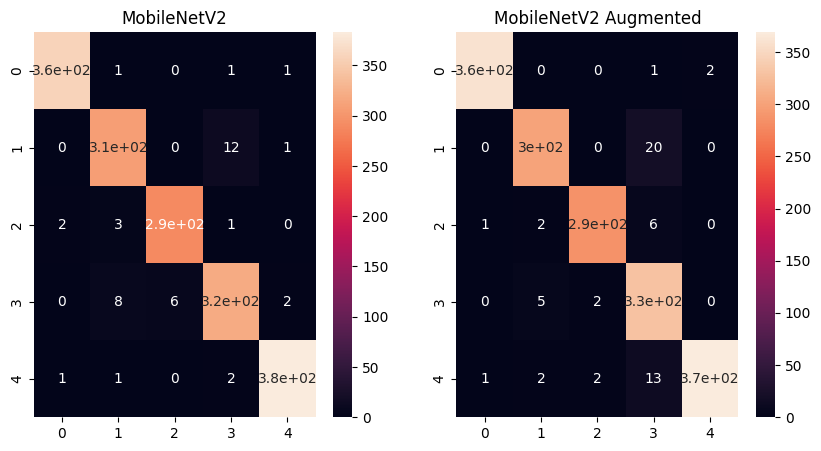

In [63]:
# MobileNetV2
cm_mobilenetv2 = generate_confusion_matrix(model_mobilenetv2, mobilenetv2_generator_ns)
cm_mobilenetv2_aug = generate_confusion_matrix(model_mobilenetv2_aug, mobilenetv2_generator_ns)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(cm_mobilenetv2, annot=True, ax=ax[0])
sns.heatmap(cm_mobilenetv2_aug, annot=True, ax=ax[1])
ax[0].set_title('MobileNetV2')
ax[1].set_title('MobileNetV2 Augmented')

plt.show()

MobileNetV2 also correctly classifies 'elephant' and 'sheep' well but has some confusion between 'cow', 'butterfly', and 'squirrel'. After augmentation, it shows improvement in classifying 'cow' and 'sheep', but at the cost of increased confusion between 'elephant' and 'butterfly'

/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 615ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 611ms/step


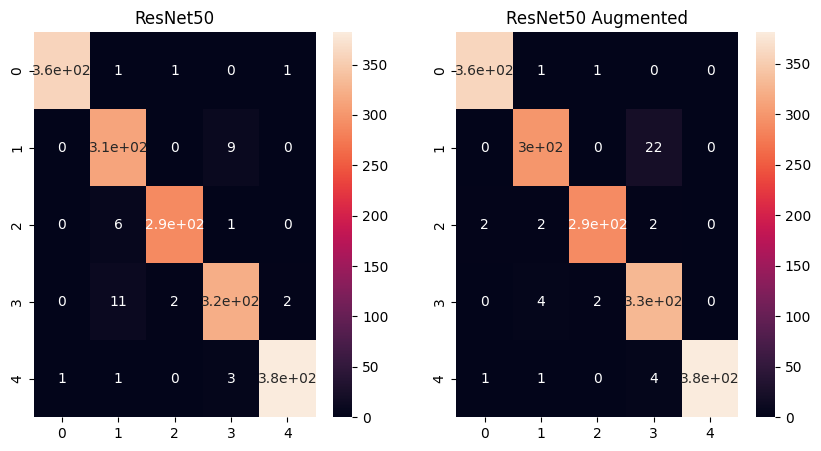

In [64]:
# ResNet50
cm_resnet50 = generate_confusion_matrix(model_resnet50, resnet50_generator_ns)
cm_resnet50_aug = generate_confusion_matrix(model_resnet50_aug, resnet50_generator_ns)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(cm_resnet50, annot=True, ax=ax[0])
sns.heatmap(cm_resnet50_aug, annot=True, ax=ax[1])
ax[0].set_title('ResNet50')
ax[1].set_title('ResNet50 Augmented')

plt.show()

ResNet50 has a high number of correct classifications for 'elephant' and 'sheep' but confuses 'cow' with 'squirrel'.
Augmentation seems to improve the classification of 'cow', with a notable increase in correct predictions and reduction in confusion with 'squirrel'

ResNet50 appears to be the best option among the three, given its high test accuracy without augmentation (97.71%) and the smaller gap between training and validation accuracy, suggesting better generalization than VGG16. However, since the augmentation does not help us significantly (and slows the training process), I will be omitting it in my final CNN architecture and training strategy

# Task 3

ResNet50 already showcases impressive accuracy, but to further refine its performance, I will:

- extend the training process to minimize validation error, incorporating early stopping to prevent overfitting
- engage in fine-tuning by unlocking a layer of the pre-trained ResNet50 model, again utilizing early stopping for optimization

## Model Architecture
- ResNet50 initialized with ImageNet weights and an input size of (224,224,3)
- GlobalAvgPool2D layer
- Dense layer with 512 nodes and ReLU activation
- Output Dense layer with 5 nodes and softmax activation

## Hyperparameters
- Adam Optimizer
- Adaptive learning rate is utilized within the Adam Optimizer
- Cross-Entropy Loss is the standard for classification tasks to effectively differentiate between good and bad predictions
- An `EarlyStop` mechanism is employed instead of a fixed epoch count, monitoring the validation loss with a patience of 5, which is deliberately set higher than the standard 3 to account for Adam's propensity for local minima
- Validation Loss is the primary metric, as it offers a more reliable measure of generalization than accuracy, a hypothesis supported by previous trial outcomes

## Training Approach
Employed a two-stage training process using a pre-trained ResNet50 network:

1. The initial stage is focused on training the Dense layers to optimize the weights while the ResNet50 base layers remain frozen

2. The model from Stage 1's training was advanced using two distinct approaches:

- Method 1: The Dense layers are frozen, while the last two layers of ResNet50 are unfrozen for fine-tuning

- Method 2: Both the Dense layers and the last two layers of ResNet50 are kept active for further fine-tuning, although this is anticipated to be less effective compared to Method 1

The method resulting in the lowest validation loss is chosen for the final model configuration and subsequently assessed using the test dataset

### First Stage

We will reinitialise the ResNet50 model to prevent data leakage

In [71]:
# Define ResNet50 model and data generators
model_resnet50, train_generator_resnet50, validation_generator_resnet50, test_generator_resnet50 = build_model_and_loaders(ResNet50, preprocess_input_resnet50)

# Define an early stopping callback with a patience of 5
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

# Define a model checkpoint callback that saves the best model weights only
model_checkpoint = ModelCheckpoint('resnet50_best.weights.h5', save_best_only=True, monitor='val_loss', save_weights_only=True)

# Train the model with the callbacks. Since we have early stopping, we can set a high number of epochs and let the callback handle the training duration
history_resnet50 = model_resnet50.fit(
    train_generator_resnet50, 
    validation_data=validation_generator_resnet50, 
    epochs=50, 
    callbacks=[early_stopping, model_checkpoint]
)

Found 5849 images belonging to 5 classes.
Found 646 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.
Epoch 1/50


/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


183/183 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8857 - loss: 0.3789 - val_accuracy: 0.9737 - val_loss: 0.0774
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 148s 810ms/step - accuracy: 0.9755 - loss: 0.0665 - val_accuracy: 0.9628 - val_loss: 0.1039
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 138s 752ms/step - accuracy: 0.9828 - loss: 0.0431 - val_accuracy: 0.9613 - val_loss: 0.1274
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 146s 794ms/step - accuracy: 0.9900 - loss: 0.0271 - val_accuracy: 0.9659 - val_loss: 0.1287
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 144s 788ms/step - accuracy: 0.9926 - loss: 0.0202 - val_accuracy: 0.9768 - val_loss: 0.0874
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 150s 812ms/step - accuracy: 0.9995 - loss: 0.0043 - val_accuracy: 0.9721 - val_loss: 0.0943


In [72]:
# Load the best weights
model_resnet50.load_weights('resnet50_best.weights.h5')

### Second Stage

#### Method 1

Next, we'll refine the model through fine-tuning by adjusting the layer availability. In the first approach, we'll keep the output layers fixed and make the final layer of the pre-trained model trainable

In [73]:
for layer in model_resnet50.layers[0].layers[-3:]:
    layer.trainable = True
for layer in model_resnet50.layers[-2:]:
    layer.trainable = False

model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Method 1: Freeze the weights of the output layers
model_checkpoint_m1 = ModelCheckpoint('resnet50_best_m1.weights.h5', save_best_only=True, monitor='val_loss', save_weights_only=True)

In [74]:
# Train the model with the callbacks
history_resnet50_m1 = model_resnet50.fit(train_generator_resnet50, validation_data=validation_generator_resnet50, epochs=100, callbacks=[early_stopping, model_checkpoint_m1])

Epoch 1/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9824 - loss: 0.0547 - val_accuracy: 0.9737 - val_loss: 0.0756
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 147s 805ms/step - accuracy: 0.9857 - loss: 0.0538 - val_accuracy: 0.9721 - val_loss: 0.0740
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 149s 812ms/step - accuracy: 0.9828 - loss: 0.0494 - val_accuracy: 0.9721 - val_loss: 0.0734
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 148s 809ms/step - accuracy: 0.9857 - loss: 0.0504 - val_accuracy: 0.9721 - val_loss: 0.0732
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 150s 820ms/step - accuracy: 0.9869 - loss: 0.0464 - val_accuracy: 0.9706 - val_loss: 0.0732
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 164s 896ms/step - accuracy: 0.9860 - loss: 0.0494 - val_accuracy: 0.9721 - val_loss: 0.0731
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 164s 895ms/step - accuracy: 0.9872 - loss: 0.0424 - val_accuracy: 0.9706 - val_loss: 0.0731
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 168s 916ms/step - accuracy: 0.9

The training output for the model indicates high and stable training accuracy, suggesting effective learning, while the validation accuracy shows minor fluctuations but generally remains steady. Losses on both fronts decrease slightly, indicating marginal improvements in predictive performance over 16 epochs. There is no evident overfitting, as validation loss does not increase. Early stopping would likely have halted training around the 10th epoch due to the lack of substantial improvement thereafter, signifying that the model has reached its performance plateau with the current setup

In [75]:
# Revert the weights back to the best ones before fine-tuning
model_resnet50.load_weights('resnet50_best.weights.h5')

/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 10 variables. 


### Stage 2

#### Method 2

We'll allow both the last layer of the pre-trained model and the output layers to be trainable

In [76]:
for layer in model_resnet50.layers[-2:]:
    layer.trainable = True

model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
model_checkpoint_m2 = ModelCheckpoint('resnet50_best_m2.weights.h5', save_best_only=True, monitor='val_loss', save_weights_only=True)

In [78]:
# train the model with the callbacks. Since we have early stopping, we don't need to worry about the number of epochs
history_resnet50_m2 = model_resnet50.fit(train_generator_resnet50, validation_data=validation_generator_resnet50, epochs=50, callbacks=[early_stopping, model_checkpoint_m2])

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.9560 - loss: 0.1384 - val_accuracy: 0.9628 - val_loss: 0.1124
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 164s 897ms/step - accuracy: 0.9740 - loss: 0.0766 - val_accuracy: 0.9613 - val_loss: 0.1450
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 174s 950ms/step - accuracy: 0.9826 - loss: 0.0469 - val_accuracy: 0.9690 - val_loss: 0.1065
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 167s 912ms/step - accuracy: 0.9892 - loss: 0.0306 - val_accuracy: 0.9768 - val_loss: 0.0732
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 169s 924ms/step - accuracy: 0.9939 - loss: 0.0196 - val_accuracy: 0.9536 - val_loss: 0.1737


In this output, the model's training accuracy improves significantly from 95.60% to 99.39% over five epochs, while the validation accuracy peaks at 97.68% in the fourth epoch before dropping to 95.36%. The training loss decreases consistently, but the validation loss increases in the fifth epoch, which may indicate the onset of overfitting as the model becomes too specialized to the training data and performs less effectively on the validation set.

Comparing this to the earlier output, the initial training here starts from a lower accuracy but increases more sharply, and the validation accuracy reaches a higher peak. However, the notable increase in validation loss by the fifth epoch contrasts with the more stable validation loss seen previously

Hence, method 1 gives us a lower validation loss and we will thus use the weights from the first method for our final model

In [79]:
model_resnet50.load_weights('resnet50_best_m1.weights.h5')

# test the model accuracy
test_loss, test_acc = model_resnet50.evaluate(test_generator_resnet50)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 6 variables. 
/Users/tammiekoh/venv-metal/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 583ms/step - accuracy: 0.9774 - loss: 0.0745
Test accuracy: 0.9747207760810852
Test loss: 0.0773640125989914


The final model achieved a test accuracy of approximately 97.47% and a test loss of 0.0774. This, however, is less than the original pre-finetuned model. To further improve performance, I could have experimented with unfreezing more layers, adjusting hyperparameters such as learning rates, and applying advanced regularization strategies like dropout or L2 regularization. Addressing the dataset handling warning noted during training could also enhance efficiency. Additionally, extending training epochs and employing a broader set of evaluation metrics, including precision and F1-score, could provide deeper insights into model performance and areas for enhancement. These strategies could potentially elevate the fine-tuned model beyond its original capabilities